This notebook is for a tutorial on multi-class sentiment analysis using HuggingFace transformers. We are using BERT.



https://www.youtube.com/watch?v=NjndMvmIiec&t=1206s

## Intro

In [1]:
!pip install -q transformers accelerate datasets bertviz umap-learn seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.29.165 which is incompatible.


twitter_multi_class_sentiment.csv

In [2]:
import pandas as pd



df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv')


In [3]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Dataset Analysis

In [4]:
import matplotlib.pyplot as plt

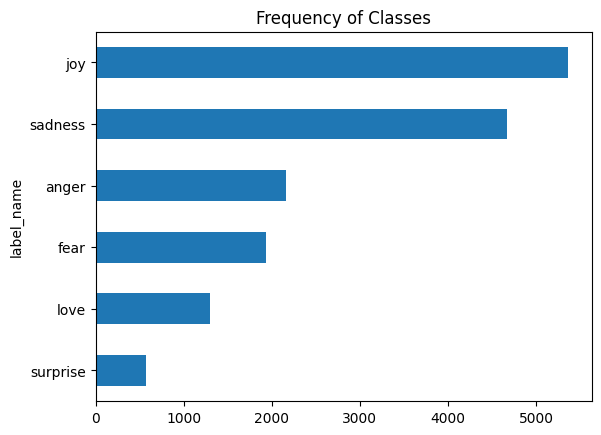

In [5]:
label_counts = df['label_name'].value_counts(ascending=True)

label_counts.plot.barh()

plt.title("Frequency of Classes")

plt.show()

In [6]:
df['Words per Tweet'] = df['text'].str.split().apply(len)

df

,text,label,label_name,Words per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

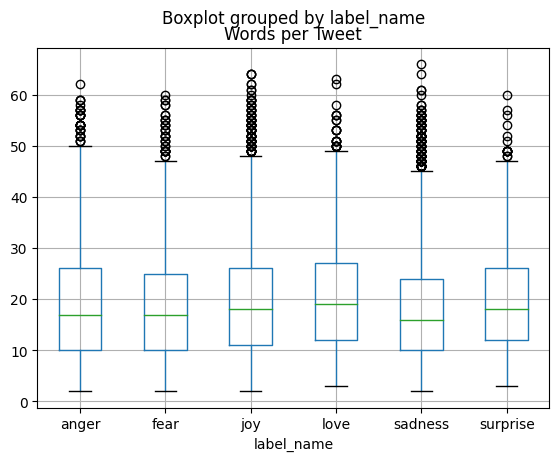

In [7]:
df.boxplot("Words per Tweet", by="label_name")

## Texts to Tokens Conversion

In [8]:
from transformers import AutoTokenizer



checkpoint = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
text = "I love tennis. Aryna Sabalenka is the best!"

encoded_text = tokenizer(text)

encoded_text

{'input_ids': [101, 1045, 2293, 5093, 1012, 12098, 18279, 7842, 10264, 2368, 2912, 2003, 1996, 2190, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [11]:
from sklearn.model_selection import train_test_split



train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])

test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape


((11200, 4), (3200, 4), (1600, 4))

In [12]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(

    {"train":Dataset.from_pandas(train, preserve_index=False),

    "test":Dataset.from_pandas(test, preserve_index=False),

    "validation":Dataset.from_pandas(validation, preserve_index=False)

    }

)



dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotion/Sentiment Data

In [13]:
example = dataset['train'][0]

example

{'text': 'i started feeling better towards the afternoon and now i still intend to finish off some things in my to do list',
 'label': 1,
 'label_name': 'joy',
 'Words per Tweet': 22}

In [14]:
# changed 'batch' in tutorial to 'examples' out of preference

def tokenize(examples):

  temp=tokenizer(examples['text'])

  return temp

In [15]:
print(tokenize(example))

{'input_ids': [101, 1045, 2318, 3110, 2488, 2875, 1996, 5027, 1998, 2085, 1045, 2145, 13566, 2000, 3926, 2125, 2070, 2477, 1999, 2026, 2000, 2079, 2862, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [16]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [17]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [18]:
emotion_encoded['train'][0]

{'text': 'i started feeling better towards the afternoon and now i still intend to finish off some things in my to do list',
 'label': 1,
 'label_name': 'joy',
 'Words per Tweet': 22,
 'input_ids': [101,
  1045,
  2318,
  3110,
  2488,
  2875,
  1996,
  5027,
  1998,
  2085,
  1045,
  2145,
  13566,
  2000,
  3926,
  2125,
  2070,
  2477,
  1999,
  2026,
  2000,
  2079,
  2862,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [19]:
# label2id, id2label



label2id = label2id = {x['label_name']:x['label'] for x in dataset['train']}

id2label = {v:k for k,v in label2id.items()}

In [20]:
label2id, id2label

({'joy': 1, 'love': 2, 'anger': 3, 'sadness': 0, 'fear': 4, 'surprise': 5},
 {1: 'joy', 2: 'love', 3: 'anger', 0: 'sadness', 4: 'fear', 5: 'surprise'})

In [21]:
# my way of doing it is much better :)

#label_names = dataset['train'].unique('label_name')

#label_names

In [22]:
#labels = dataset['train'].unique('label')

#labels

In [23]:
#id2label = dict(zip(labels, label_names))

#id2label

## Model Building

In [24]:
from transformers import AutoModel

import torch

In [25]:
# really not sure what the point of this is since you redefine model below

model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
from transformers import AutoModelForSequenceClassification, AutoConfig

In [27]:
# or this

num_labels = len(label2id)

num_labels

6

In [28]:
# not sure why the model is added to.device if using Trainer()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(checkpoint, label2id=label2id, id2label=id2label)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model.config.num_labels

6

In [30]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [31]:
from transformers import TrainingArguments



batch_size = 64

training_dir = 'bert_base_train_dir'



training_args = TrainingArguments(

    output_dir=training_dir,

    overwrite_output_dir=True,

    num_train_epochs=6,

    learning_rate=2e-5,

    per_device_train_batch_size=batch_size,

    per_device_eval_batch_size=batch_size,

    weight_decay=0.01,

    logging_strategy="epoch",

    evaluation_strategy='epoch',

    disable_tqdm=False,

    report_to="all"

)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Now we need a ``` compute_metrics ``` function to evaluate our fine-tuned model. Hugging Face does not have this built in.

In [32]:
!pip install -q evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
import evaluate



accuracy = evaluate.load("accuracy")




In [34]:
import numpy as np





def compute_metrics_evaluate(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [35]:
from sklearn.metrics import accuracy_score, f1_score

In [36]:
def compute_metrics(eval_pred):

   labels = eval_pred.label_ids

   preds = eval_pred.predictions.argmax(-1)



   f1 = f1_score(labels, preds, average='weighted')

   acc = accuracy_score(labels, preds)



   return {

       'accuracy': acc,

       'f1': f1

   }


## Build Trainer

In [37]:
from transformers import Trainer



trainer = Trainer(model=model,

                  args=training_args,

                  #compute_metrics=compute_metrics_evaluate,

                  compute_metrics=compute_metrics,

                  train_dataset=emotion_encoded['train'],

                  eval_dataset=emotion_encoded['validation'],

                  tokenizer=tokenizer

                  )

In [38]:
import os
os.environ["WANDB_MODE"] = "disabled"

In [39]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.280900,0.696093,0.791250,0.758920
2,0.432800,0.256304,0.915000,0.914828
3,0.200800,0.185500,0.927500,0.927307
4,0.145700,0.172822,0.930625,0.930888
5,0.115800,0.168762,0.926250,0.926666
6,0.101600,0.163872,0.929375,0.929247


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=528, training_loss=0.3795982978560708, metrics={'train_runtime': 390.1611, 'train_samples_per_second': 172.237, 'train_steps_per_second': 1.353, 'total_flos': 2089999059943680.0, 'train_loss': 0.3795982978560708, 'epoch': 6.0})

In [40]:
eval_results = trainer.evaluate()
print(eval_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.1638719141483307, 'eval_accuracy': 0.929375, 'eval_f1': 0.9292473343078975, 'eval_runtime': 3.1266, 'eval_samples_per_second': 511.746, 'eval_steps_per_second': 4.158, 'epoch': 6.0}


In [41]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.1513703465461731,
 'test_accuracy': 0.93375,
 'test_f1': 0.9335714060655037,
 'test_runtime': 6.3581,
 'test_samples_per_second': 503.294,
 'test_steps_per_second': 3.932}

In [42]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       933
           1       0.95      0.96      0.95      1072
           2       0.87      0.85      0.86       261
           3       0.93      0.92      0.93       432
           4       0.88      0.90      0.89       387
           5       0.81      0.77      0.79       115

    accuracy                           0.93      3200
   macro avg       0.90      0.89      0.90      3200
weighted avg       0.93      0.93      0.93      3200



In [44]:
label2id

{'joy': 1, 'love': 2, 'anger': 3, 'sadness': 0, 'fear': 4, 'surprise': 5}

In [45]:
# plot confusion matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

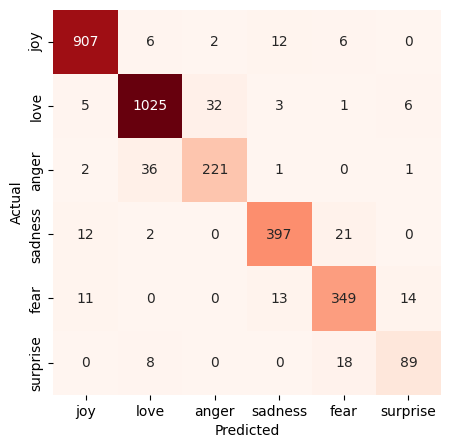

In [46]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [47]:
text = 'I love playing tennis. It makes me feel so good.'

input_encoded = tokenizer(text, return_tensors ='pt').to(device)
input_encoded

{'input_ids': tensor([[ 101, 1045, 2293, 2652, 5093, 1012, 2009, 3084, 2033, 2514, 2061, 2204,
         1012,  102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [48]:
def get_prediction(text):

    input_encoded = tokenizer(text, return_tensors ='pt').to(device)


    with torch.no_grad():
        outputs = model(**input_encoded)
    
    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

In [49]:
get_prediction(text)

'joy'

In [52]:
text = 'Trump is a Nazi. I cannot believe he won.'

get_prediction(text)

'joy'

In [53]:
text = 'Trump is a Nazi.'
get_prediction(text)

'anger'

In [54]:
text = 'I cannot believe he won!'
get_prediction(text)

'joy'

In [55]:
text = 'I love Trump!'
get_prediction(text)

'joy'

In [56]:
trainer.save_model("bert_base-uncased-sentiment-model")

In [57]:
print(os.listdir("/kaggle/working"))


['bert_base-uncased-sentiment-model', 'bert_base_train_dir', '.virtual_documents']


In [58]:
import os

model_dir = "/kaggle/working/bert_base-uncased-sentiment-model"
print(os.listdir(model_dir))


['vocab.txt', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'model.safetensors', 'config.json', 'training_args.bin']


In [59]:
import json

with open(f"{model_dir}/config.json") as f:
    config = json.load(f)
print(config)


{'_name_or_path': 'bert-base-uncased', 'architectures': ['BertForSequenceClassification'], 'attention_probs_dropout_prob': 0.1, 'classifier_dropout': None, 'gradient_checkpointing': False, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'id2label': {'0': 'sadness', '1': 'joy', '2': 'love', '3': 'anger', '4': 'fear', '5': 'surprise'}, 'initializer_range': 0.02, 'intermediate_size': 3072, 'label2id': {'anger': 3, 'fear': 4, 'joy': 1, 'love': 2, 'sadness': 0, 'surprise': 5}, 'layer_norm_eps': 1e-12, 'max_position_embeddings': 512, 'model_type': 'bert', 'num_attention_heads': 12, 'num_hidden_layers': 12, 'pad_token_id': 0, 'position_embedding_type': 'absolute', 'problem_type': 'single_label_classification', 'torch_dtype': 'float32', 'transformers_version': '4.45.1', 'type_vocab_size': 2, 'use_cache': True, 'vocab_size': 30522}


In [60]:
# use pipeline for prediction 
from transformers import pipeline

classifier = pipeline('text-classification', model=model_dir)

classifier(['I am mad at you', 'you are stupid', 'i did not win', 'i lost'])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'anger', 'score': 0.988461971282959},
 {'label': 'anger', 'score': 0.6223273277282715},
 {'label': 'joy', 'score': 0.46798011660575867},
 {'label': 'sadness', 'score': 0.9572821259498596}]

In [61]:
dataset['train'][0 ]

{'text': 'i started feeling better towards the afternoon and now i still intend to finish off some things in my to do list',
 'label': 1,
 'label_name': 'joy',
 'Words per Tweet': 22}